# Lab2: Adversarial Attacks on Deep Neural Networks

## Load Dataset

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist, cifar10, cifar100
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
#loading the MNIST 
fashion_mnist = tf.keras.datasets.fashion_mnist
(xTrain, yTrain), (xTest, yTest) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


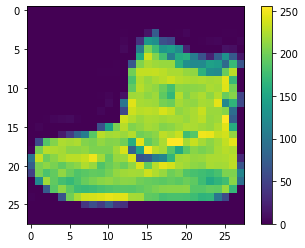

In [ ]:
# Plot picture
plt.figure()
plt.imshow(xTrain[0])
plt.colorbar()
plt.grid(False)
plt.show()

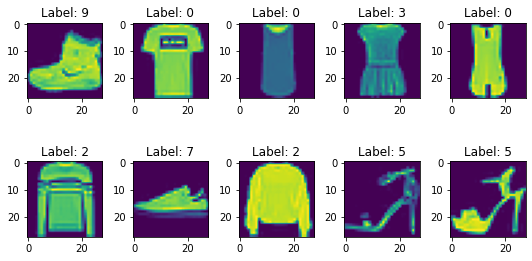

In [ ]:
num = 10
images = xTrain[:num]
labels = yTrain[:num]

num_row = 2
num_col = 5 # plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i])
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [ ]:
xTrain[0].shape

(28, 28)

In [5]:
# Preprocessing
img_rows, img_cols = xTrain[0].shape
numOfClasses = 10

xTrain = xTrain / 255.0
xTest = xTest / 255.0

## Baseline DNN

**Q1**: Implement baseline DNN

In [6]:
baseModel = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])
baseModel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
baseModel.fit(xTrain, yTrain, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5351 - accuracy: 0.8116
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4008 - accuracy: 0.8539
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3672 - accuracy: 0.8672
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3444 - accuracy: 0.8728
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3307 - accuracy: 0.8783
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3190 - accuracy: 0.8819
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3075 - accuracy: 0.8864
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2982 - accuracy: 0.8892
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2919 - accuracy: 0.8920
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.282

In [7]:
print("Base loss and accuracy on regular images:", baseModel.evaluate(x=xTest, y=yTest, verbose=0))

Base loss and accuracy on regular images: [0.3400658667087555, 0.8801000118255615]


## FGSM based untargeted attacks

**Q2**: Implement FGS untargetd attack

In [ ]:
def get_prtbtns(X, label, loss_func, model):
    perturbations = np.zeros((X.shape[0], X.shape[1], X.shape[2]))
    for i in range(X.shape[0]):
        x,y = X[i:i+1],label[i]
        with tf.GradientTape() as gt:
            gt.watch(x)
            p = model(x)
            loss = loss_func(y, p)
        grad = gt.gradient(loss, x)
        perturbations[i] = tf.sign(grad)
    return perturbations

xTest_tensor = tf.convert_to_tensor(xTest)
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
perturbations = get_prtbtns(xTest_tensor, yTest, loss_func, baseModel)

In [ ]:
def FGS_untargeted_attack(X, label, model, eps=1):
    newX = np.zeros((X.shape[0], X.shape[1], X.shape[2]))
    
    for i in range(X.shape[0]):
      newX[i] = X[i] + e/255.0 * perturbations[i]
    newX = tf.clip_by_value(newX, 0, 1)
    return newX

**Q3**: Calculate the fraction of test images that were correctly classified by the baseline DNN that are mis-classified after adversarial perturbation, as a function of $\epsilon$, and plot the result.

In [ ]:
epss = [1, 5, 10, 20, 30, 40, 50]
rpt = pd.DataFrame(index=epss, columns=['Confuse_frac'])

for e in epss:
    xTestAftAttack = FGS_untargeted_attack(xTest, yTest, baseModel, eps=e)

    loss, acc = baseModel.evaluate(x=xTestAftAttack, y=yTest, verbose=0)
    rpt.loc[e, 'Confuse_frac'] = acc


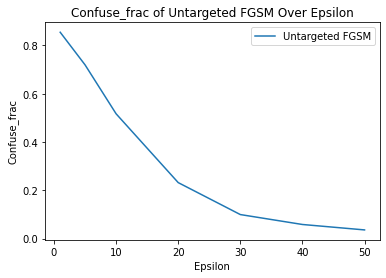

In [ ]:
plt.plot(epss, rpt['Confuse_frac'], label = "Untargeted FGSM")
plt.xlabel('Epsilon')
plt.ylabel('Confuse_frac')
plt.title('Confuse_frac of Untargeted FGSM Over Epsilon')
plt.legend()
plt.show()

## FGSM based targeted attacks

**Q4**: Implement FGS targetd attack

In [ ]:
yTest_target = (yTest + 1) % 10

xTest_tensor = tf.convert_to_tensor(xTest)
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
perturbations_target = get_prtbtns(xTest_tensor, yTest_target, loss_func, baseModel)

In [ ]:
def FGS_targeted_attack(X, label, model, eps=1):
    newX = np.zeros((X.shape[0], X.shape[1], X.shape[2]))
    
    for i in range(X.shape[0]):
      newX[i] = X[i] - e/255.0 * perturbations_target[i]
    newX = tf.clip_by_value(newX, 0, 1)
    return newX

**Q5**:Report the attack’s success rate as a function of parameter $\epsilon$ where success rate is defined as the fraction of test images that were correctly classified by the baseline DNN that are mis-classified after adversarial perturbations with label (i+1)%10.

In [ ]:
epss = [1, 5, 10, 20, 30, 40, 50]
rpt = pd.DataFrame(index=epss, columns=['Mislead_frac'])

for e in epss:
    xTestAftAttack = FGS_targeted_attack(xTest, yTest_target, baseModel, eps=e)
    
    loss, acc = baseModel.evaluate(x=xTestAftAttack, y=yTest, verbose=0)
    rpt.loc[e, 'Mislead_frac'] = acc
rpt

,Mislead_frac
1,0.88
5,0.859
10,0.7734
20,0.4515
30,0.2198
40,0.0866
50,0.0354


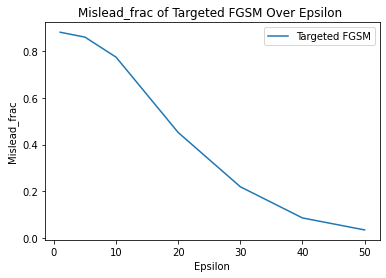

In [ ]:
plt.plot(epss, rpt['Mislead_frac'], label = "Targeted FGSM")
plt.xlabel('Epsilon')
plt.ylabel('Mislead_frac')
plt.title('Mislead_frac of Targeted FGSM Over Epsilon ')
plt.legend()
plt.show()

## Adversarial Retraining against Untargeted FGSM Attacks:

**Q6**: Append the adversarially perturbed images to training set, but using their correct labels.

In [ ]:
e = 10
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def attack_train(X, train_target, model, eps=10):
    newX = np.zeros((X.shape[0], X.shape[1], X.shape[2]))
    for i in range(X.shape[0]):
      newX[i] = X[i] + e/255.0 * train_target[i]
    newX = tf.clip_by_value(newX, 0, 1)
    return newX

xTrain_tensor = tf.convert_to_tensor(xTrain)
perturbations_train_target = get_prtbtns(xTrain_tensor, yTrain, loss_func, baseModel)
xTrain_AftAttack = attack_train(xTrain, perturbations_train_target, baseModel, eps=10)

In [ ]:
newX = np.concatenate((xTrain, xTrain_AftAttack), axis=0)
newY = np.concatenate((yTrain, yTrain), axis=0)

In [ ]:
advModel = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])
advModel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
advModel.fit(newX, newY, epochs=10)

Epoch 1/10
3750/3750 [==============================] - 9s 2ms/step - loss: 0.4575 - accuracy: 0.8431
Epoch 2/10
3750/3750 [==============================] - 9s 2ms/step - loss: 0.3103 - accuracy: 0.8935
Epoch 3/10
3750/3750 [==============================] - 9s 2ms/step - loss: 0.2660 - accuracy: 0.9071
Epoch 4/10
3750/3750 [==============================] - 9s 2ms/step - loss: 0.2451 - accuracy: 0.9135
Epoch 5/10
3750/3750 [==============================] - 9s 2ms/step - loss: 0.2247 - accuracy: 0.9207
Epoch 6/10
3750/3750 [==============================] - 9s 2ms/step - loss: 0.2123 - accuracy: 0.9237
Epoch 7/10
3750/3750 [==============================] - 9s 2ms/step - loss: 0.2031 - accuracy: 0.9275
Epoch 8/10
3750/3750 [==============================] - 9s 2ms/step - loss: 0.1912 - accuracy: 0.9312
Epoch 9/10
3750/3750 [==============================] - 9s 2ms/step - loss: 0.1867 - accuracy: 0.9315
Epoch 10/10
3750/3750 [==============================] - 9s 2ms/step - loss: 0.181

**Q7**: Report the classification accuracy of the adversarially retrained DNN on the original test dataset that contains only clean inputs. Implement FGSM based untargeted attacks using images from the clean test set on the adversarially retrained DNN. Report the success rate of your attack. Is the adversarially retrained DNN robust against adversarial perturbations? 

In [ ]:
new_loss, new_acc = advModel.evaluate(x=xTest, y=yTest, verbose=0)
print("The new accuracy for clean test input: ", new_acc)

The new accuracy for clean test input:  0.8755000233650208


In [ ]:
e=10
perturbations = get_prtbtns(xTest_tensor, yTest, loss_func, advModel)
xTestAftAttack = FGS_untargeted_attack(xTest, yTest, advModel, eps=e)
new_attack_loss, new_attack_acc = advModel.evaluate(x=xTestAftAttack, y=yTest, verbose=0)
print("The new accuracy for untargeted attack input: ", new_attack_acc)
# costPerPixel = # Your Code

The new accuracy for untargeted attack input:  0.7906000018119812


## Challenge

In this section, I'm going to try IFGSM.

In [21]:
eps = 5 / 255.0
steps = 20
step_alpha = 0.005

In [45]:
def IFGS_untargeted_attack(x, y, loss_func, model):
    perturbation = np.zeros(x.shape)
    for step in range(steps):
        with tf.GradientTape() as gt:
            gt.watch(x)
            p = model(x)
            loss = loss_func(y, p)
        grad = gt.gradient(loss, x)
        perturbation = tf.sign(grad)
        x += step_alpha * perturbation
        x = tf.clip_by_value(x, 0, 1)
    x +=  eps * perturbation
    x = tf.clip_by_value(x, 0, 1)
    # print(x)
    return x

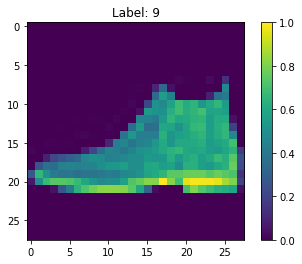

In [39]:
# Plot picture
plt.figure()
plt.imshow(xTest[0])
plt.title('Label: {}'.format(yTest[0]))
plt.colorbar()
plt.grid(False)
plt.show()

In [46]:
xTest_tensor = tf.convert_to_tensor(xTest)
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
new_img = IFGS_untargeted_attack(xTest_tensor[0:1], yTest[0], loss_func, baseModel)

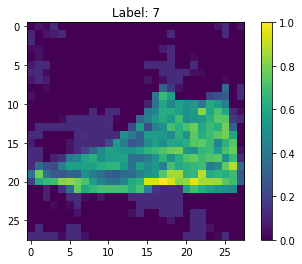

In [47]:
new_y = tf.argmax(baseModel(new_img)[0])
plt.figure()
plt.imshow(new_img[0])
plt.title('Label: {}'.format(new_y))
plt.colorbar()
plt.grid(False)
plt.show()

In [67]:
save_new_img = np.array(new_img)[0]*255
# ssave_new_img = save_new_img.astype(int)

In [69]:
from PIL import Image
im = Image.fromarray(save_new_img)
im.convert('RGB').save("Challenge_picture.jpeg")